## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [100]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [101]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")
        
        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [102]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [103]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [104]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [105]:
CUDA_DEVICE_ID = 0  # change if needed

In [106]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 1')

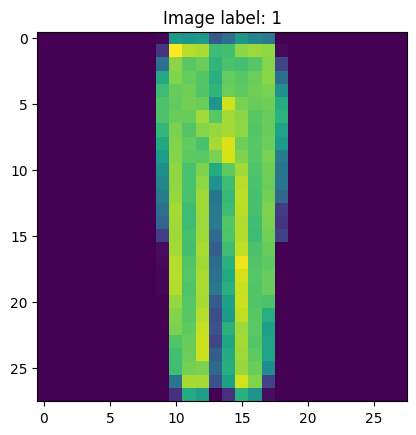

In [107]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [108]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), # 26 x 26 x 6
            nn.ReLU(), 
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # 24 x 24 x 6
            nn.ReLU(), 
        )
        
        self.pooling = nn.AdaptiveAvgPool2d((8, 8))
        
        self.out = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.out(x)
        return x

In [138]:
# Creating model instance
model_task_1 = MyModel()
# your code here

Не забудьте перенести модель на выбранный `device`!

In [139]:
model_task_1.to(device)

MyModel(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (pooling): AdaptiveAvgPool2d(output_size=(8, 8))
  (out): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

Локальные тесты для проверки вашей модели доступны ниже:

In [140]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [141]:
best_weights_1 = None

In [142]:
   # your code here
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import copy

# your code here
EPOCHS = 10
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.001)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,                    
    steps_per_epoch=len(train_data_loader), 
    epochs=EPOCHS,                     
)
criterion = nn.CrossEntropyLoss()

best_acc = 0

for epoch in range(EPOCHS):
    avg_loss = []
    
    for x, y in tqdm(train_data_loader):
        optimizer.zero_grad()
        y_pred = model_task_1(x.to(device))
        loss = criterion(y_pred, y.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        avg_loss.append(loss.item())
        
    train_acc = get_accuracy(model_task_1, train_data_loader)
    test_acc = get_accuracy(model_task_1, test_data_loader)  
        
    epoch_loss = sum(avg_loss) / len(avg_loss)
    tqdm.write(f"Epoch {epoch + 1} loss: {epoch_loss}")
    tqdm.write(f"train_acc: {train_acc} test_acc: {test_acc}")
    
    if test_acc > best_acc:
        tqdm.write("Веса обновлены")
        best_acc = test_acc
        best_weights_1 = copy.deepcopy(model_task_1.state_dict())

100%|██████████| 1875/1875 [00:06<00:00, 307.05it/s]


Epoch 1 loss: 0.49058825800418854
train_acc: 0.8744666576385498 test_acc: 0.8672000169754028
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 318.92it/s]


Epoch 2 loss: 0.3298515477110942
train_acc: 0.8969833254814148 test_acc: 0.883899986743927
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 317.15it/s]


Epoch 3 loss: 0.29861317199071247
train_acc: 0.9018166661262512 test_acc: 0.8862000107765198
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 323.94it/s]


Epoch 4 loss: 0.2611221288656195
train_acc: 0.9193833470344543 test_acc: 0.8970999717712402
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 319.17it/s]


Epoch 5 loss: 0.21978396830360095
train_acc: 0.9383166432380676 test_acc: 0.904699981212616
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 322.78it/s]


Epoch 6 loss: 0.170981315354382
train_acc: 0.9549499750137329 test_acc: 0.9125999808311462
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 318.44it/s]


Epoch 7 loss: 0.12173269939891374
train_acc: 0.9726499915122986 test_acc: 0.9176999926567078
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 323.32it/s]


Epoch 8 loss: 0.07263630452530148
train_acc: 0.9845333099365234 test_acc: 0.9229000210762024
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 315.03it/s]


Epoch 9 loss: 0.03999788464383067
train_acc: 0.9922333359718323 test_acc: 0.9261000156402588
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 317.74it/s]


Epoch 10 loss: 0.02471340824476162
train_acc: 0.9935833215713501 test_acc: 0.9254000186920166


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [143]:
model_task_1.load_state_dict(best_weights_1)

<All keys matched successfully>

In [144]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.99223


In [145]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9261


Проверка, что необходимые пороги пройдены:

In [147]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [148]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче. 

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [149]:
# Creating model instance
model_task_2 = MyModel().to(device)
# your code here

In [150]:
best_weights_2 = None

In [151]:
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import copy
# your code here
EPOCHS = 20

# optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model_task_2.parameters(), lr=0.001)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,                    
    steps_per_epoch=len(train_data_loader), 
    epochs=EPOCHS,                     
)
criterion = nn.CrossEntropyLoss()

best_acc = 0

for epoch in range(EPOCHS):
    avg_loss = []
    
    for x, y in tqdm(train_data_loader):
        optimizer.zero_grad()
        y_pred = model_task_2(x.to(device))
        loss = criterion(y_pred, y.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        avg_loss.append(loss.item())
        
    train_acc = get_accuracy(model_task_2, train_data_loader)
    test_acc = get_accuracy(model_task_2, test_data_loader)  
        
    epoch_loss = sum(avg_loss) / len(avg_loss)
    tqdm.write(f"Epoch {epoch + 1} loss: {epoch_loss}")
    tqdm.write(f"train_acc: {train_acc} test_acc: {test_acc}")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_weights_2 = copy.deepcopy(model_task_2.state_dict())
        tqdm.write(f"Веса обновлены")
    
    
 
        

100%|██████████| 1875/1875 [00:06<00:00, 305.58it/s]


Epoch 1 loss: 0.49073596455256147
train_acc: 0.8607833385467529 test_acc: 0.8510000109672546
Веса обновлены


100%|██████████| 1875/1875 [00:06<00:00, 309.06it/s]


Epoch 2 loss: 0.3321731511394183
train_acc: 0.8934833407402039 test_acc: 0.8783000111579895
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 314.69it/s]


Epoch 3 loss: 0.28837705824673177
train_acc: 0.909250020980835 test_acc: 0.8937000036239624
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 321.93it/s]


Epoch 4 loss: 0.2668055949827035
train_acc: 0.9074000120162964 test_acc: 0.8878999948501587


100%|██████████| 1875/1875 [00:05<00:00, 324.16it/s]


Epoch 5 loss: 0.2527749616995454
train_acc: 0.9001666903495789 test_acc: 0.873199999332428


100%|██████████| 1875/1875 [00:05<00:00, 322.48it/s]


Epoch 6 loss: 0.2403860849345724
train_acc: 0.9284999966621399 test_acc: 0.8988000154495239
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 323.68it/s]


Epoch 7 loss: 0.21643592210362356
train_acc: 0.9291999936103821 test_acc: 0.8913999795913696


100%|██████████| 1875/1875 [00:05<00:00, 320.22it/s]


Epoch 8 loss: 0.19567790893365938
train_acc: 0.9393333196640015 test_acc: 0.8970999717712402


100%|██████████| 1875/1875 [00:05<00:00, 318.21it/s]


Epoch 9 loss: 0.16697730810592573
train_acc: 0.9608666896820068 test_acc: 0.906000018119812
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 322.58it/s]


Epoch 10 loss: 0.13616061762130507
train_acc: 0.9699333310127258 test_acc: 0.909600019454956
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 320.19it/s]


Epoch 11 loss: 0.10260503938610976
train_acc: 0.9727833271026611 test_acc: 0.9041000008583069


100%|██████████| 1875/1875 [00:05<00:00, 325.26it/s]


Epoch 12 loss: 0.08539983321593608
train_acc: 0.9756500124931335 test_acc: 0.9060999751091003


100%|██████████| 1875/1875 [00:05<00:00, 322.22it/s]


Epoch 13 loss: 0.05949813835108265
train_acc: 0.989300012588501 test_acc: 0.9117000102996826
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 324.73it/s]


Epoch 14 loss: 0.03706705131980367
train_acc: 0.9926000237464905 test_acc: 0.9153000116348267
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 323.90it/s]


Epoch 15 loss: 0.0189514086028581
train_acc: 0.996749997138977 test_acc: 0.9168000221252441
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 324.16it/s]


Epoch 16 loss: 0.009077372557771801
train_acc: 0.998283326625824 test_acc: 0.9197999835014343
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 323.23it/s]


Epoch 17 loss: 0.0034846516619343086
train_acc: 0.9997000098228455 test_acc: 0.9204000234603882
Веса обновлены


100%|██████████| 1875/1875 [00:05<00:00, 321.53it/s]


Epoch 18 loss: 0.0014130889348618661
train_acc: 0.999916672706604 test_acc: 0.9200000166893005


100%|██████████| 1875/1875 [00:05<00:00, 329.11it/s]


Epoch 19 loss: 0.0006407231327811851
train_acc: 0.9999666810035706 test_acc: 0.9205999970436096
Веса обновлены


100%|██████████| 1875/1875 [00:06<00:00, 300.38it/s]


Epoch 20 loss: 0.00044777659320108953
train_acc: 0.9999666810035706 test_acc: 0.9210000038146973
Веса обновлены


Проверка архитектуры:

In [152]:
model_task_2.load_state_dict(best_weights_2)

<All keys matched successfully>

In [153]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [154]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.99997


In [155]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.921


Проверка, что переобучение присутствует:

In [156]:
print(train_acc_task_2 - test_acc_task_2)

tensor(0.0790)


In [157]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [158]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return) 
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче. 

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [159]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [160]:
class MyBetterModel(nn.Module):
    def __init__(self):
        super(MyBetterModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), # 26 x 26 x 6
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # 24 x 24 x 6
            nn.BatchNorm2d(32),
            nn.ReLU(), 
        )
        
        self.pooling = nn.AdaptiveAvgPool2d((8, 8))
        
        self.out = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.out(x)
        return x

In [179]:
model_task_3 = MyBetterModel().to(device)

In [162]:
best_weights_3 = None

In [180]:
# your code here
from tqdm import tqdm
import copy
from torch.optim.lr_scheduler import OneCycleLR
# your code here
EPOCHS = 5

optimizer = torch.optim.Adam(model_task_3.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model_task_3.parameters(), lr=0.001)
# scheduler = OneCycleLR(
#     optimizer,
#     max_lr=0.01,                    
#     steps_per_epoch=len(train_data_loader), 
#     epochs=EPOCHS,                     
# )
criterion = nn.CrossEntropyLoss()

best_acc = 0

for epoch in range(EPOCHS):
    avg_loss = []
    
    for x, y in tqdm(train_data_loader):
        optimizer.zero_grad()
        y_pred = model_task_3(x.to(device))
        loss = criterion(y_pred, y.to(device))
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        avg_loss.append(loss.item())
        
    train_acc = get_accuracy(model_task_3, train_data_loader)
    test_acc = get_accuracy(model_task_3, test_data_loader)  
        
    epoch_loss = sum(avg_loss) / len(avg_loss)
    tqdm.write(f"Epoch {epoch + 1} loss: {epoch_loss}")
    diff = train_acc-test_acc
    tqdm.write(f"train_acc: {train_acc} test_acc: {test_acc} diff: {diff}")
    
    if diff <= 0.015 and  test_acc > best_acc:
        best_acc = test_acc
        best_weights_3 = copy.deepcopy(model_task_3.state_dict())
        tqdm.write(f"Веса обновлены")
 

100%|██████████| 1875/1875 [00:06<00:00, 280.62it/s]


Epoch 1 loss: 0.4778924557308356
train_acc: 0.8873000144958496 test_acc: 0.8741999864578247 diff: 0.013100028038024902
Веса обновлены


100%|██████████| 1875/1875 [00:06<00:00, 302.09it/s]


Epoch 2 loss: 0.3064541900932789
train_acc: 0.9020166397094727 test_acc: 0.8844000101089478 diff: 0.017616629600524902


100%|██████████| 1875/1875 [00:06<00:00, 296.48it/s]


Epoch 3 loss: 0.26488264818688234
train_acc: 0.9157833456993103 test_acc: 0.8948000073432922 diff: 0.020983338356018066


100%|██████████| 1875/1875 [00:06<00:00, 288.09it/s]


Epoch 4 loss: 0.2436507780060172
train_acc: 0.9203000068664551 test_acc: 0.8991000056266785 diff: 0.02120000123977661


100%|██████████| 1875/1875 [00:06<00:00, 291.74it/s]


Epoch 5 loss: 0.2240043858083586
train_acc: 0.9284166693687439 test_acc: 0.9018999934196472 diff: 0.02651667594909668


100%|██████████| 1875/1875 [00:06<00:00, 300.03it/s]


Epoch 6 loss: 0.210388888429602
train_acc: 0.9319499731063843 test_acc: 0.9067999720573425 diff: 0.025150001049041748


100%|██████████| 1875/1875 [00:06<00:00, 301.59it/s]


Epoch 7 loss: 0.19474283763815958
train_acc: 0.9353166818618774 test_acc: 0.9068999886512756 diff: 0.028416693210601807


100%|██████████| 1875/1875 [00:06<00:00, 305.89it/s]


Epoch 8 loss: 0.18808454170152544
train_acc: 0.9391666650772095 test_acc: 0.9054999947547913 diff: 0.03366667032241821


100%|██████████| 1875/1875 [00:06<00:00, 305.89it/s]


Epoch 9 loss: 0.17378020562628904
train_acc: 0.935949981212616 test_acc: 0.9028000235557556 diff: 0.03314995765686035


100%|██████████| 1875/1875 [00:06<00:00, 306.69it/s]


Epoch 10 loss: 0.17278197252216437
train_acc: 0.9490166902542114 test_acc: 0.9143000245094299 diff: 0.034716665744781494


Проверка архитектуры:

In [181]:
model_task_3.load_state_dict(best_weights_3)

<All keys matched successfully>

In [182]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [183]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.8873


In [184]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8742


Проверка, что переобучение присутствует:

In [185]:
print(train_acc_task_3 - test_acc_task_3)

tensor(0.0131)


In [186]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert test_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [187]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!